# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from mrcnn.visualize import display_images

from samples.potato import potato

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "model_weights/mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


### Configurations

In [2]:
config = potato.PotatoConfig()
POTATO_DIR = os.path.join(ROOT_DIR, "datasets/potato_2")

# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time


    NAME = "potato"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    
    
     # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes
    
    
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    
    ##********** 1)ANCHORS GENERATION - for RPN*********
    
    #     Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (4, 8, 16,32, 64)
    TOP_DOWN_PYRAMID_SIZE = 256
    
    ##********** 2)PROPOSAL LAYER ********* (no deep learning involved here)
    
     # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 256 ##in dataset generation

    ## tf.image.non_max_suppression(boxes,scores,max_output_size,iou_threshold=0.5,...)
    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD=0.99#0.7
    #A float representing the threshold for deciding whether boxes overlap too much with respect to IOU.    
    ## POST_NMS_ROIS_TRAINING~ POST_NMS_ROIS_INFERENCE ~proposal_count ~ max_output_size
    
    
    
    
    
    
    
    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 128
    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD=0.5#0.3 above iou_threshold
    
    
    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE=0.65
    
    # Percent of positive ROIs used to train classifier/mask heads
    ROI_POSITIVE_RATIO = 0.5
    
    
    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 128
    # Max number of final detections
    DETECTION_MAX_INSTANCES = 128


    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 30

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 10
    LEARNING_RATE=0.0001
    
    
    TRAIN_BN=True
    
    
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        128
DETECTION_MIN_CONFIDENCE       0.65
DETECTION_NMS_THRESHOLD        0.5
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE           

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset



In [4]:

# Training dataset
dataset_train = potato.PotatoDataset()
dataset_train.load_potato(POTATO_DIR, "train")
dataset_train.prepare()

# Validation dataset
dataset_val= potato.PotatoDataset()
dataset_val.load_potato(POTATO_DIR, "val")
dataset_val.prepare()

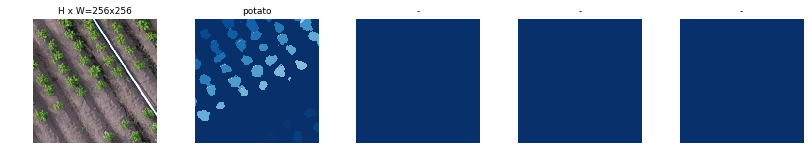

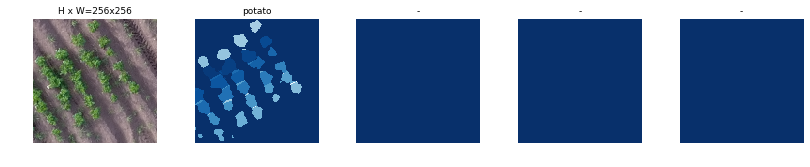

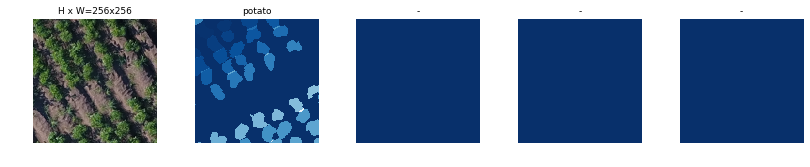

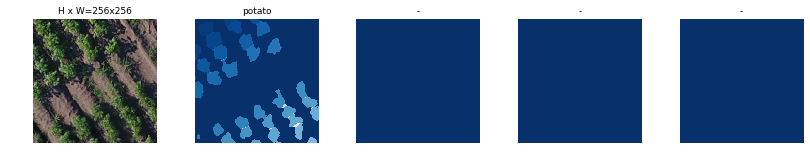

In [5]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [6]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [ ]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=60, 
            layers='heads')


Starting at epoch 0. LR=0.0001

Checkpoint Path: /home/meli/Desktop/git/Mask_RCNN/logs/potato20190206T1212/mask_rcnn_potato_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed

/home/meli/hb/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/meli/hb/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/60
30/30 [==============================] - 1713s 57s/step - loss: 5.1322 - rpn_class_loss: 0.2749 - rpn_bbox_loss: 2.4675 - mrcnn_class_loss: 0.7656 - mrcnn_bbox_loss: 0.9069 - mrcnn_mask_loss: 0.7172 - val_loss: 5.1384 - val_rpn_class_loss: 0.1809 - val_rpn_bbox_loss: 2.6095 - val_mrcnn_class_loss: 0.6328 - val_mrcnn_bbox_loss: 1.0242 - val_mrcnn_mask_loss: 0.6910
Epoch 2/60
30/30 [==============================] - 1654s 55s/step - loss: 4.1914 - rpn_class_loss: 0.2320 - rpn_bbox_loss: 2.1012 - mrcnn_class_loss: 0.3925 - mrcnn_bbox_loss: 0.7755 - mrcnn_mask_loss: 0.6901 - val_loss: 4.3308 - val_rpn_class_loss: 0.1646 - val_rpn_bbox_loss: 2.2524 - val_mrcnn_class_loss: 0.3457 - val_mrcnn_bbox_loss: 0.9013 - val_mrcnn_mask_loss: 0.6668
Epoch 3/60
30/30 [==============================] - 1654s 55s/step - loss: 4.4948 - rpn_class_loss: 0.2256 - rpn_bbox_loss: 2.6817 - mrcnn_class_loss: 0.2311 - mrcnn_bbox_loss: 0.6991 - mrcnn_mask_loss: 0.6573 - val_loss: 3.6819 - val_rpn_class_l

Epoch 23/60
30/30 [==============================] - 1655s 55s/step - loss: 3.1878 - rpn_class_loss: 0.1176 - rpn_bbox_loss: 2.0509 - mrcnn_class_loss: 0.1993 - mrcnn_bbox_loss: 0.4120 - mrcnn_mask_loss: 0.4079 - val_loss: 2.8190 - val_rpn_class_loss: 0.1255 - val_rpn_bbox_loss: 1.6548 - val_mrcnn_class_loss: 0.1715 - val_mrcnn_bbox_loss: 0.4589 - val_mrcnn_mask_loss: 0.4084
Epoch 24/60
30/30 [==============================] - 1653s 55s/step - loss: 2.8463 - rpn_class_loss: 0.1243 - rpn_bbox_loss: 1.4495 - mrcnn_class_loss: 0.3927 - mrcnn_bbox_loss: 0.4487 - mrcnn_mask_loss: 0.4311 - val_loss: 2.8839 - val_rpn_class_loss: 0.1248 - val_rpn_bbox_loss: 1.5727 - val_mrcnn_class_loss: 0.2427 - val_mrcnn_bbox_loss: 0.5043 - val_mrcnn_mask_loss: 0.4395
Epoch 25/60
30/30 [==============================] - 1656s 55s/step - loss: 3.2615 - rpn_class_loss: 0.1325 - rpn_bbox_loss: 1.9953 - mrcnn_class_loss: 0.2653 - mrcnn_bbox_loss: 0.4484 - mrcnn_mask_loss: 0.4201 - val_loss: 2.4040 - val_rpn_clas

Epoch 45/60
11/30 [==========>...................] - ETA: 16:58 - loss: 2.4068 - rpn_class_loss: 0.0877 - rpn_bbox_loss: 1.3902 - mrcnn_class_loss: 0.2154 - mrcnn_bbox_loss: 0.3556 - mrcnn_mask_loss: 0.3580

## Detection

In [ ]:
class InferenceConfig(config.__class__):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
# model_path = model.find_last()
model_path = os.path.join(MODEL_DIR,'potato20190204T1549/mask_rcnn_potato_0055.h5')

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

original_image           shape: (256, 256, 3)         min:   37.00000  max:  231.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  256.00000  int64
gt_class_id              shape: (29,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (29, 4)               min:    0.00000  max:  256.00000  int32
gt_mask                  shape: (256, 256, 29)        min:    0.00000  max:    1.00000  bool


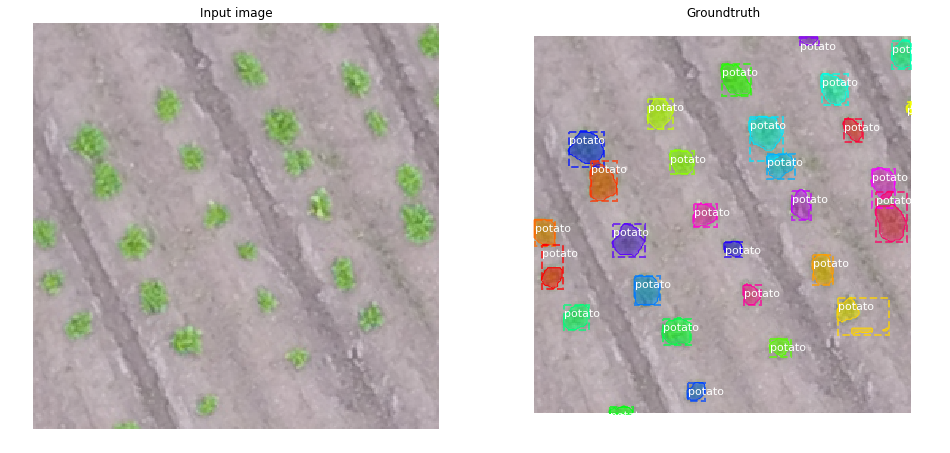

In [10]:
# Test on a  image


image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

axs_=get_ax(rows=1, cols=2, size=8)

axs_[0].imshow(original_image)
axs_[0].set_title('Input image')
axs_[0].axis('off')

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names,ax=axs_[1])

axs_[1].set_title('Groundtruth')

plt.show()

Processing 1 images
image                    shape: (256, 256, 3)         min:   37.00000  max:  231.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -66.90000  max:  114.20000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32


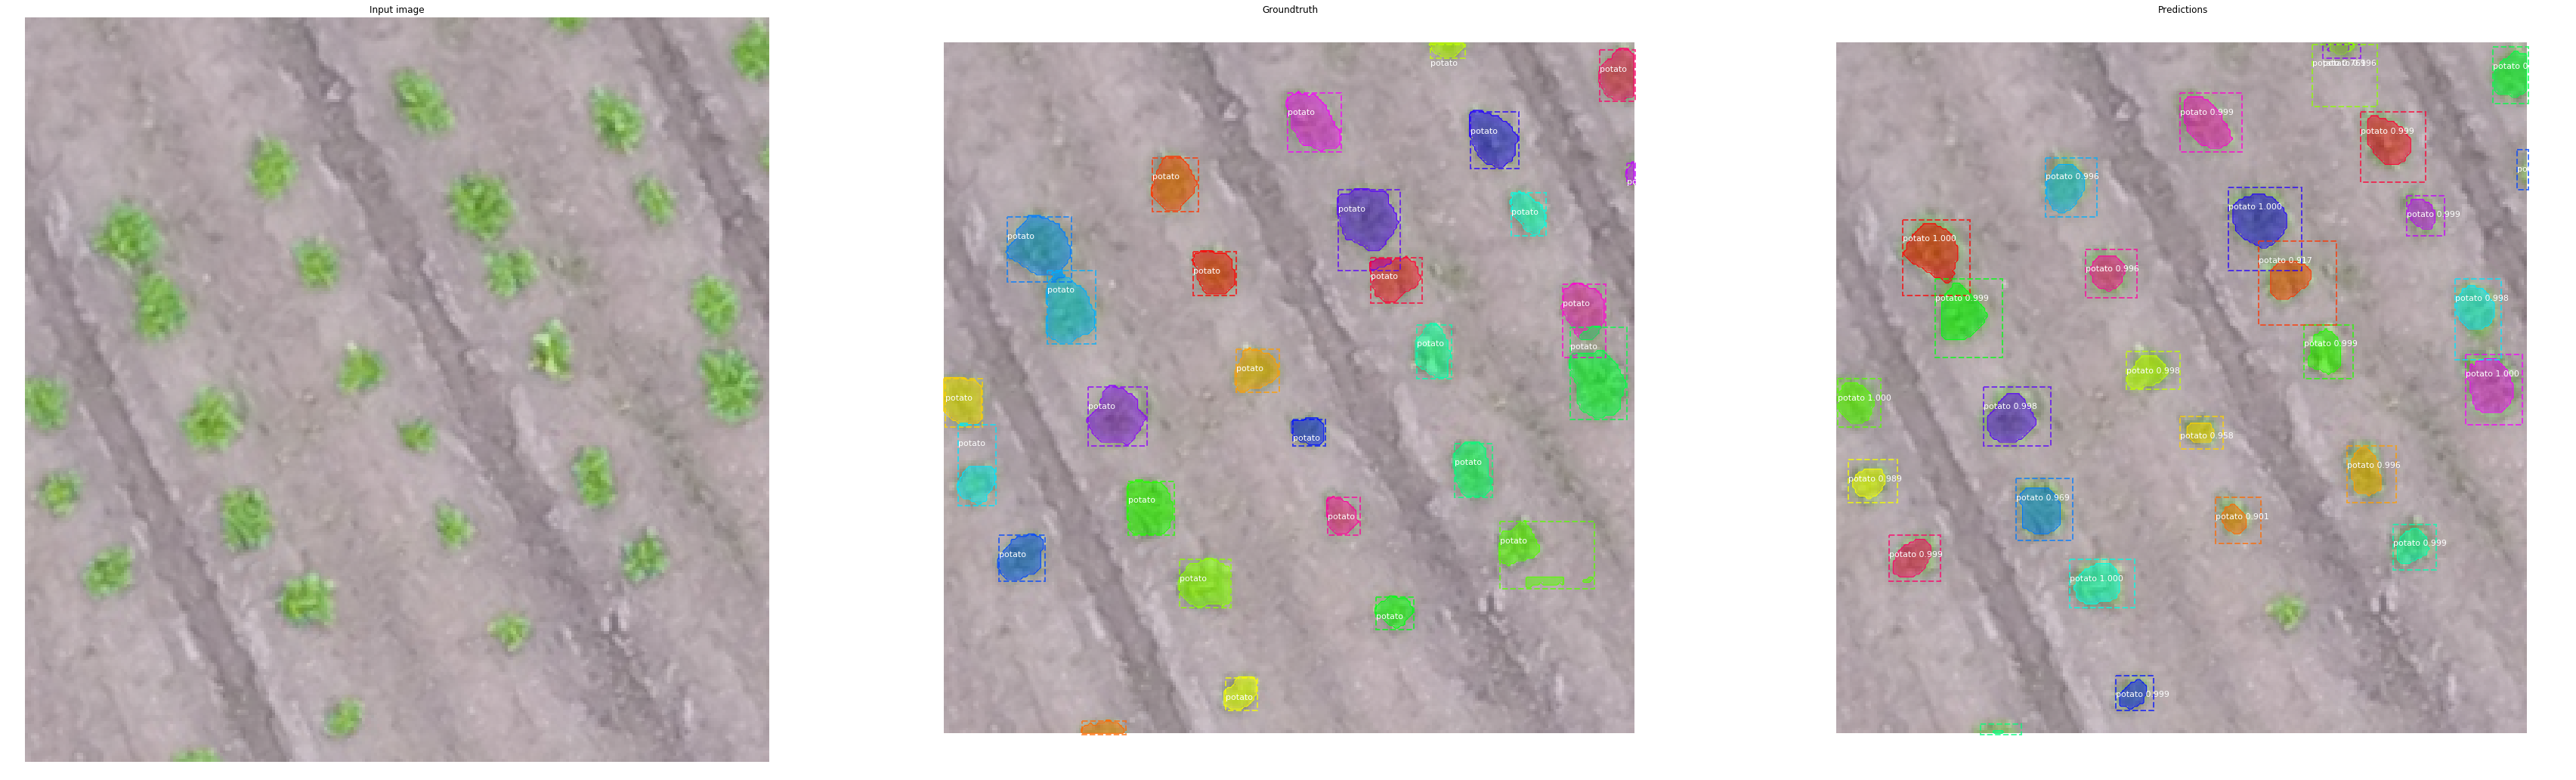

In [11]:
results = model.detect([original_image], verbose=1)


r = results[0]
axs_=get_ax(rows=1, cols=3, size=20)

axs_[0].imshow(original_image)
axs_[0].set_title('Input image')
axs_[0].axis('off')
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names,ax=axs_[1])
axs_[1].set_title('Groundtruth')


visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=axs_[2])
axs_[2].set_title('Predictions')

plt.show()




## Evaluation

In [12]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
# image_ids = np.random.choice(dataset_val.image_ids, 70)
image_ids = dataset_val.image_ids
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.6741672414218902


In [ ]:
# utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
#                        r['rois'], r['class_ids'], r['scores'], r['masks'],
#                        verbose=1)
